  # SpaceTime Matrix demo on Spider HPC

This notebook demonstrates `stm` on the Spider system of GRS group, TUDelft. It uses [JupyterDaskOnSLURM](https://github.com/RS-DAT/JupyterDaskOnSLURM) to scale up. 

### Data used for this notebook
- Interferogram stack: `/project/caroline/Share/stacks/nl_veenweiden_s1_asc_t088/`
- Polygons of NL crop pacels: `/project/caroline/Public/demo_sarxarray/data/brp/brpgewaspercelen_concept_2022_wgs84.gpkg`

### Setup environment
To setup the environment, please refer to the [user-guide](https://github.com/RS-DAT/JupyterDaskOnSLURM/blob/main/user-guide.md) of JupyterDaskOnSLURM. By following it, you setup a Python environment `jupyter_dask`. We assume the following setup are done inside `jupyter_dask`.

To execute this notebook, first clone the `stm` repostory to your local and install it with `demo` extra options

```sh
git clone git@github.com:MotionbyLearning/stm.git
cd stm
pip install .[demo]
```

You will also need `sarxarray` to load the interferogram stack as a start point. To install `sarxarray`, do:
```sh
cd ..
git clone git@github.com:MotionbyLearning/sarxarray.git
cd sarxarray
pip install .
```

After installation, you can refer to the [user-guide](https://github.com/RS-DAT/JupyterDaskOnSLURM/blob/main/user-guide.md) again on how to access this Notebook on HPC to your local.

--- Initiate a Dask cluster here ---

--- you can use the Dask icon on the left of the Jupyter environment ---

--- In this demo we init a cluster with 16 workers ---

In [1]:
from dask.distributed import Client

client = Client("tcp://10.0.2.186:41977")

### Load a SLC stack using SarXarray

In [2]:
import numpy as np
from pathlib import Path
import sarxarray

In [3]:
# SLC stack processed by Doris V5
path = Path('/project/caroline/Share/stacks/nl_veenweiden_s1_asc_t088/stack')

# Make a list of SLCs to read
f_slc = 'cint_srd.raw'
list_slcs = [p/f_slc for p in path.rglob(('[0-9]' * 8)) if not p.match('20200325')]

# Geo referenced coordinates
f_lat = [path/'20210730'/'phi.raw']
f_lon = [path/'20210730'/'lam.raw']

# Metadata of the stack
shape=(10018, 68656)
dtype = np.dtype([('re', np.float32), ('im', np.float32)])

In [4]:
len(list_slcs)

378

In [5]:
list_slcs[:10]

[PosixPath('/project/caroline/Share/stacks/nl_veenweiden_s1_asc_t088/stack/20200418/cint_srd.raw'),
 PosixPath('/project/caroline/Share/stacks/nl_veenweiden_s1_asc_t088/stack/20210712/cint_srd.raw'),
 PosixPath('/project/caroline/Share/stacks/nl_veenweiden_s1_asc_t088/stack/20161012/cint_srd.raw'),
 PosixPath('/project/caroline/Share/stacks/nl_veenweiden_s1_asc_t088/stack/20210817/cint_srd.raw'),
 PosixPath('/project/caroline/Share/stacks/nl_veenweiden_s1_asc_t088/stack/20161217/cint_srd.raw'),
 PosixPath('/project/caroline/Share/stacks/nl_veenweiden_s1_asc_t088/stack/20181026/cint_srd.raw'),
 PosixPath('/project/caroline/Share/stacks/nl_veenweiden_s1_asc_t088/stack/20170609/cint_srd.raw'),
 PosixPath('/project/caroline/Share/stacks/nl_veenweiden_s1_asc_t088/stack/20210706/cint_srd.raw'),
 PosixPath('/project/caroline/Share/stacks/nl_veenweiden_s1_asc_t088/stack/20181219/cint_srd.raw'),
 PosixPath('/project/caroline/Share/stacks/nl_veenweiden_s1_asc_t088/stack/20201120/cint_srd.raw')]

In [6]:
! du -csh /project/caroline/Share/stacks/nl_veenweiden_s1_asc_t088/stack/????????/cint_srd.raw | grep total

1.9T	total


In [7]:
list_slcs = list_slcs[0:100] # 100 images for example

In [8]:
reading_chunks = (2000,2000)
# Load complex data
stack = sarxarray.from_binary(list_slcs, shape, dtype=dtype, chunks=reading_chunks)

# Load coordinates
lat = sarxarray.from_binary(f_lat, shape, vlabel="lat", dtype=np.float32, chunks=reading_chunks)
lon = sarxarray.from_binary(f_lon, shape, vlabel="lon", dtype=np.float32, chunks=reading_chunks)
stack = stack.assign_coords(lat = (("azimuth", "range"), lat.squeeze().lat.data), lon = (("azimuth", "range"), lon.squeeze().lon.data))
stack

<xarray.Dataset>
Dimensions:    (azimuth: 10018, range: 68656, time: 100)
Coordinates:
  * azimuth    (azimuth) int64 0 1 2 3 4 5 ... 10013 10014 10015 10016 10017
  * range      (range) int64 0 1 2 3 4 5 ... 68650 68651 68652 68653 68654 68655
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
    lat        (azimuth, range) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    lon        (azimuth, range) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(2000, 2000, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(2000, 2000, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(2000, 2000, 1), meta=np.ndarray>

In [9]:
stack_subset = stack.sel(azimuth=range(20_00,60_00), range=range(140_00,220_00))
stack_subset

<xarray.Dataset>
Dimensions:    (azimuth: 4000, range: 8000, time: 100)
Coordinates:
  * azimuth    (azimuth) int64 2000 2001 2002 2003 2004 ... 5996 5997 5998 5999
  * range      (range) int64 14000 14001 14002 14003 ... 21996 21997 21998 21999
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
    lat        (azimuth, range) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    lon        (azimuth, range) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(2000, 2000, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(2000, 2000, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(2000, 2000, 1), meta=np.ndarray>

### Select a subset

In [10]:
mrm = stack_subset.slcstack.mrm()
mrm

<xarray.DataArray 'amplitude' (azimuth: 4000, range: 8000)>
dask.array<mean_agg-aggregate, shape=(4000, 8000), dtype=float32, chunksize=(2000, 2000), chunktype=numpy.ndarray>
Coordinates:
  * azimuth  (azimuth) int64 2000 2001 2002 2003 2004 ... 5996 5997 5998 5999
  * range    (range) int64 14000 14001 14002 14003 ... 21996 21997 21998 21999
    lat      (azimuth, range) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    lon      (azimuth, range) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>

In [11]:
mrm = mrm.compute()

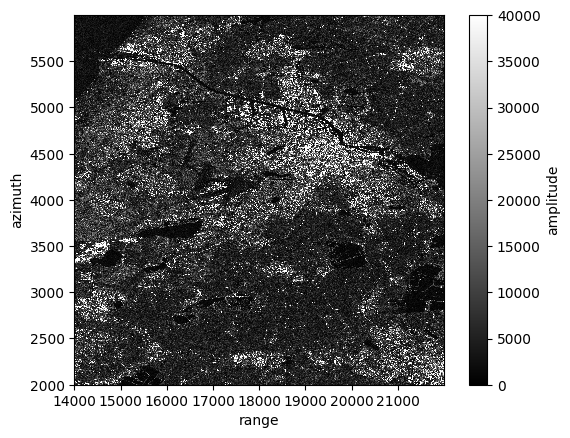

In [12]:
# Visualize
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.imshow(mrm)
ax.set_aspect(2)
im = mrm.plot(ax=ax, cmap='gray')
im.set_clim([0, 40000])

### Export to a Space Time Matrix

In [13]:
stack_subset2 = stack_subset.sel(azimuth=range(20_00,40_00), range=range(180_00,200_00))
stmat = stack_subset2.slcstack.point_selection(threshold=2, method="amplitude_dispersion",chunks=20_000)
stmat

<xarray.Dataset>
Dimensions:    (time: 100, points: 500142)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
    lat        (points) float32 dask.array<chunksize=(20000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(20000,), meta=np.ndarray>
    azimuth    (points) int64 dask.array<chunksize=(20000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(20000,), meta=np.ndarray>
Dimensions without coordinates: points
Data variables:
    complex    (points, time) complex64 dask.array<chunksize=(20000, 100), meta=np.ndarray>
    amplitude  (points, time) float32 dask.array<chunksize=(20000, 100), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(20000, 100), meta=np.ndarray>

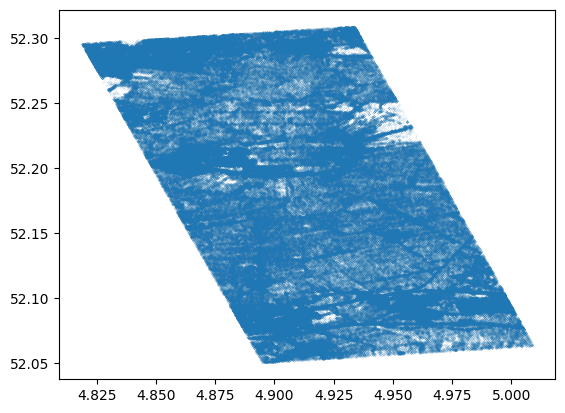

In [14]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
plt.scatter(stmat.lon.data, stmat.lat.data, s=0.005)

In [15]:
# Export to Zarr
stmat.to_zarr("stm.zarr", mode="w") # overwrite for demo

### Loading SpaceTime Matrix from Zarr

In [16]:
import xarray as xr
import stmtools
path_stm = Path('./stm.zarr')
stm_demo = xr.open_zarr(path_stm)
stm_demo

<xarray.Dataset>
Dimensions:    (points: 500142, time: 100)
Coordinates:
    azimuth    (points) int64 dask.array<chunksize=(20000,), meta=np.ndarray>
    lat        (points) float32 dask.array<chunksize=(20000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(20000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(20000,), meta=np.ndarray>
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Dimensions without coordinates: points
Data variables:
    amplitude  (points, time) float32 dask.array<chunksize=(20000, 100), meta=np.ndarray>
    complex    (points, time) complex64 dask.array<chunksize=(20000, 100), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(20000, 100), meta=np.ndarray>

### STM enrichment from Polygon file

In [17]:
# Path to the BRP polygon of NL
# Need a abs path for cluster processing
path_polygon = Path('/project/caroline/Public/demo_sarxarray/data/brp/brpgewaspercelen_concept_2022_wgs84.gpkg')

In [18]:
import geopandas as gpd
# Read one row and check columns
polygons_one_row = gpd.read_file(path_polygon, rows=1)
polygons_one_row

,category,gewas,gewascode,jaar,status,geometry
0,Bouwland,"Tarwe, winter-",233,2022,Concept,"POLYGON ((5.55271 52.50400, 5.55311 52.50411, ..."


<AxesSubplot: >

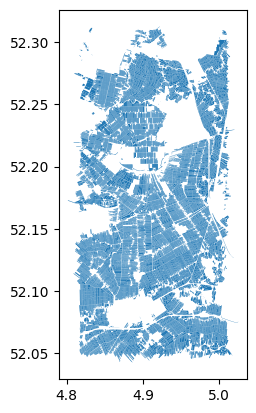

In [19]:
xmin, ymin, xmax, ymax = [
        stm_demo['lon'].data.min().compute(),
        stm_demo['lat'].data.min().compute(),
        stm_demo['lon'].data.max().compute(),
        stm_demo['lat'].data.max().compute(),
    ]
polygons = gpd.read_file(path_polygon, bbox=(xmin, ymin, xmax, ymax))
polygons.plot()

In [20]:
# Data enrichment
fields_to_query = ['gewas', 'gewascode']

# # When AoI is small and less number of chunks: directly feed in the polygon file. Multi-process can be blocked by file IO
# stm_demo = stm_demo.stm.enrich_from_polygon(path_polygon, fields_to_query)

stm_demo = stm_demo.stm.enrich_from_polygon(polygons, fields_to_query)

In [21]:
stm_demo

<xarray.Dataset>
Dimensions:    (time: 100, points: 500142)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
    azimuth    (points) int64 dask.array<chunksize=(20000,), meta=np.ndarray>
    lat        (points) float32 dask.array<chunksize=(20000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(20000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(20000,), meta=np.ndarray>
Dimensions without coordinates: points
Data variables:
    amplitude  (points, time) float32 dask.array<chunksize=(20000, 100), meta=np.ndarray>
    complex    (points, time) complex64 dask.array<chunksize=(20000, 100), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(20000, 100), meta=np.ndarray>
    gewas      (points) object dask.array<chunksize=(20000,), meta=np.ndarray>
    gewascode  (points) object dask.array<chunksize=(20000,), meta=np.ndarray>

### Subset by Polygons

In [22]:
stm_demo_subset = stm_demo.stm.subset(method='polygon', polygon=path_polygon)
stm_demo_subset

<xarray.Dataset>
Dimensions:    (time: 100, points: 181734)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
    azimuth    (points) int64 dask.array<chunksize=(20000,), meta=np.ndarray>
    lat        (points) float32 dask.array<chunksize=(20000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(20000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(20000,), meta=np.ndarray>
Dimensions without coordinates: points
Data variables:
    amplitude  (points, time) float32 dask.array<chunksize=(20000, 100), meta=np.ndarray>
    complex    (points, time) complex64 dask.array<chunksize=(20000, 100), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(20000, 100), meta=np.ndarray>
    gewas      (points) object dask.array<chunksize=(20000,), meta=np.ndarray>
    gewascode  (points) object dask.array<chunksize=(20000,), meta=np.ndarray>

In [23]:
gewascode = stm_demo_subset['gewascode'].compute()
gewascode

<xarray.DataArray 'gewascode' (points: 181734)>
array([259, 259, 259, ..., 265, 265, 265], dtype=object)
Coordinates:
    azimuth  (points) int64 2000 2000 2000 2000 2000 ... 3999 3999 3999 3999
    lat      (points) float32 52.05 52.05 52.05 52.05 ... 52.31 52.31 52.31
    lon      (points) float32 4.897 4.897 4.897 4.897 ... 4.922 4.922 4.924
    range    (points) int64 18035 18036 18038 18039 ... 19789 19795 19797 19829
Dimensions without coordinates: points

In [24]:
# Convert gewascode to classes
idx = 1
classes = gewascode
for v in np.unique(gewascode):
    classes[np.where(gewascode==v)] = idx
    idx+=1

### Visualize the croptype code

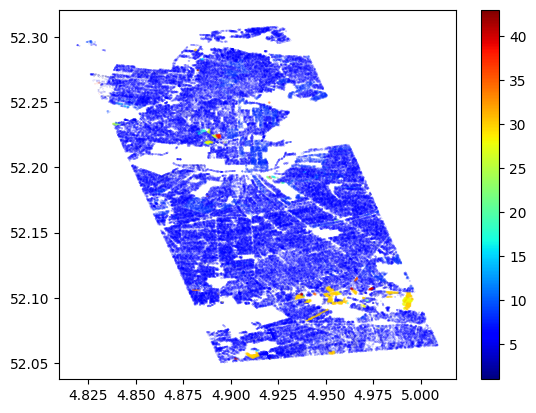

In [28]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm

colormap = cm.jet

fig, ax = plt.subplots()
plt.scatter(stm_demo_subset.lon.data, stm_demo_subset.lat.data, c=classes, s=0.003, cmap=colormap)
plt.colorbar()